In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.analysis import circular_stats
import os 
seed = 2023

### Def functions

In [2]:
def get_task_variables(data:SpikeData,bhv:BhvData,in_out:str='in'):
    # Select trials (correct and DMTS task) and create task frame
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]

    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=bhv.condition[trial_idx],
        test_stimuli=bhv.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    task = task[task['in_out']==in_out]
    return task, trial_idx

In [3]:
def delete_match(test_stimuli,code):
    code = (code-1).astype(int)
    tests_shape=test_stimuli.shape
    test_stimuli = np.concatenate([test_stimuli,np.ones((tests_shape[0],1))],axis=1)
    test_stimuli[np.arange(tests_shape[0]),code] =  np.nan
    test_stimuli = test_stimuli[:,:tests_shape[1]]
    return test_stimuli

In [4]:
def get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient,stim_num):
    all_sp_tests=[]
    if color_orient == 'color':
        test_stimuli_samp = test_stimuli_samp%10
    else:
        test_stimuli_samp = test_stimuli_samp//10

    for i_num,i_stim in enumerate(stim_num):
        i_trial, i_test = np.where(test_stimuli_samp==(i_num+1))
        tests_on = code_samples_samp[i_trial,2*i_test+6]
        sp_stim = sp_samples_samp[i_trial]
        sp_tests = SpikeData.indep_roll(sp_stim, -tests_on.astype(int), axis=1)[:, 0:550]
        if np.isnan(np.sum(sp_tests)):
            raise ValueError('nan values')
        all_sp_tests.append(sp_tests)
    return all_sp_tests

In [5]:
## Permutation test
def permutation_test(mean_select,mean_null):
    radius = mean_select[:,0]
    angle =  mean_select[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_dir_vector = np.sqrt(X**2+Y**2)
    radius = mean_null[:,0]
    angle =  mean_null[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_null_vector = np.sqrt(X**2+Y**2)
    diff=[]
    for i in range(len(ampl_dir_vector)):
        # rotate vecto to compare all values with the null vector
        shift = np.concatenate([ampl_dir_vector[i:],ampl_dir_vector[:i]])
        diff.append(shift-ampl_null_vector)
    diff=np.concatenate(diff)
    p_value = np.sum(diff<0)/len(diff)
    return p_value

In [6]:
def get_null_vector_from_samples(trials_fr,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]

    for n_it in range(n_iterations):
        all_sample1 = []
        np.random.seed(it_seed[n_it]) 
        for i_num,i_stim in enumerate(stim_num):
            all_sample1.append(np.random.choice(trials_fr[i_num], size=min_n_trials[i_num], replace=False, p=None))
        all_sample1 = np.concatenate(all_sample1)
       
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr = np.random.choice(all_sample1, size=min_n_trials[i_num], replace=True, p=None)

            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.direction_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

In [7]:
def select_rand_trials_from_samples(trials_fr,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]
    for n_it in range(n_iterations):
        np.random.seed(it_seed[n_it]) 
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr = np.random.choice(trials_fr[i_num], size=min_n_trials[i_num], replace=True, p=None)
            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.direction_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

### Read paths

In [8]:
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_bhv_lip.txt", "r")
lines_bhv = file1.readlines()
file1.close()
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_sp_lip.txt", "r")
lines_sp = file1.readlines()
file1.close()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

In [9]:
paths_bhv[16]

'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-02-09_10-42-54_Riesling_e1_r1_bhv.h5'

### Define parameters

In [10]:
n_iterations = 1000
win=100
step=1
i_neuron =2
t_before = 500
t_after = 500

In [11]:
n_bhv=paths_bhv[16]
n_sp = paths_sp[16]
s_path = os.path.normpath(n_sp).split(os.sep)
b_path = os.path.normpath(n_bhv).split(os.sep)
print(n_sp)
if b_path[-1][:19] != s_path[-1][:19]:
    raise NameError

date = s_path[-1][:19]
data = SpikeData.from_python_hdf5(n_sp)
bhv = BhvData.from_python_hdf5(n_bhv)
print(data.clustersgroup)

/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2023-02-09_10-42-54_Riesling_lip_e1_r1_sp.h5


['good' 'good' 'good' 'mua']


### Check number of trials (correct and incorrect)

In [12]:
# correct and incorrect trials
trial_idx = np.where(data.block == 1)[0]

if np.any(np.isnan(data.neuron_cond)):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond=data.neuron_cond
task_cor_inc = def_task.create_task_frame(
    condition=bhv.condition[trial_idx],
    test_stimuli=bhv.test_stimuli[trial_idx],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond = neuron_cond,
)
task_cor_inc = task_cor_inc[task_cor_inc['in_out']=='in']

        i_neuron
sample          
o0_c0         36
o1_c1        127
o1_c5        108
o5_c1         96
o5_c5        105


current,o0_c0,o1_c1,o1_c5,o5_c1,o5_c5
previous,,,,,
o0_c0,0.055556,0.062992,0.111111,0.072917,0.066667
o1_c1,0.250000,0.196850,0.351852,0.250000,0.295238
o1_c5,0.277778,0.283465,0.120370,0.250000,0.238095
o5_c1,0.277778,0.220472,0.175926,0.166667,0.209524
o5_c5,0.138889,0.236220,0.240741,0.260417,0.180952


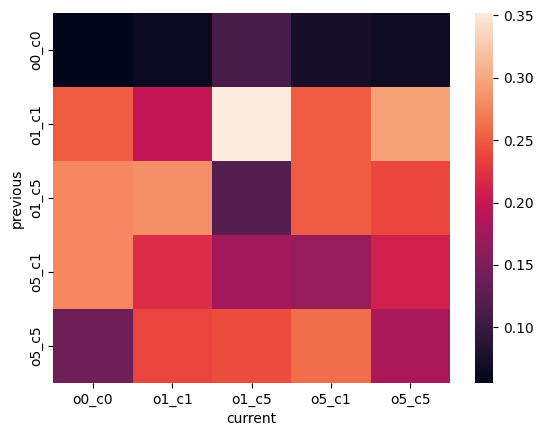

In [13]:
task_one_neuron = task_cor_inc[task_cor_inc['i_neuron']==i_neuron]
n_trials_sample = task_one_neuron[['i_neuron','sample']].groupby(['sample']).count()
print(n_trials_sample)
sorted_samples = task_one_neuron[['trial_idx','sample']].sort_values('trial_idx').reset_index(drop=True)['sample'].values
samples_dict = {'current':[],'previous':[]}
prev_sampl = sorted_samples[0]
for i_sample in sorted_samples[1:]:
    samples_dict['current'].append(i_sample)
    samples_dict['previous'].append(prev_sampl)
    prev_sampl = i_sample
samples_dict = pd.DataFrame(samples_dict)
curr_prev_sample = samples_dict.reset_index().groupby(['current','previous']).count().reset_index()
df = curr_prev_sample.pivot(index="previous", columns="current", values="index")
df['o0_c0'] = df['o0_c0']/n_trials_sample.loc['o0_c0'].values[0]
df['o1_c1'] = df['o1_c1']/n_trials_sample.loc['o1_c1'].values[0]
df['o1_c5'] = df['o1_c5']/n_trials_sample.loc['o1_c5'].values[0]
df['o5_c1'] = df['o5_c1']/n_trials_sample.loc['o5_c1'].values[0]
df['o5_c5'] = df['o5_c5']/n_trials_sample.loc['o5_c5'].values[0]
sns.heatmap(df)
df

### Select correct trials inside the rf and define task df

In [14]:
task_corr_in, idx_tr_corr_in = get_task_variables(data,bhv,in_out='in')

In [15]:
task_corr_in.head()

,i_neuron,trial_idx,sample,in_out,n_test_stimuli,code
0,0,3,o1_c1,in,2,2
1,0,9,o1_c1,in,2,2
2,0,11,o1_c1,in,2,2
3,0,18,o1_c1,in,2,2
4,0,46,o1_c1,in,2,2


In [16]:
# Select data for the relevant trials
test_stimuli = bhv.test_stimuli[idx_tr_corr_in]
code_numbers = data.code_numbers[idx_tr_corr_in]
code_samples = data.code_samples[idx_tr_corr_in]
sp_samples = data.sp_samples[idx_tr_corr_in,i_neuron]

In [17]:
task_one_neuron=task_corr_in[task_corr_in['i_neuron']==i_neuron]
task_trials = task_one_neuron['trial_idx'].values
# select trials with at least one spike
trial_idx = task_trials[np.nansum(sp_samples[task_trials],axis=1)>0]
task_fr = task_one_neuron[np.in1d(task_one_neuron['trial_idx'] , trial_idx)]

        i_neuron
sample          
o0_c0         35
o1_c1         44
o1_c5         34
o5_c1         36
o5_c5         41


current,o0_c0,o1_c1,o1_c5,o5_c1,o5_c5
previous,,,,,
o0_c0,0.171429,0.136364,0.235294,0.138889,0.243902
o1_c1,0.142857,0.295455,0.352941,0.194444,0.146341
o1_c5,0.285714,0.136364,0.176471,0.250000,0.073171
o5_c1,0.257143,0.227273,0.029412,0.138889,0.268293
o5_c5,0.142857,0.204545,0.205882,0.277778,0.243902


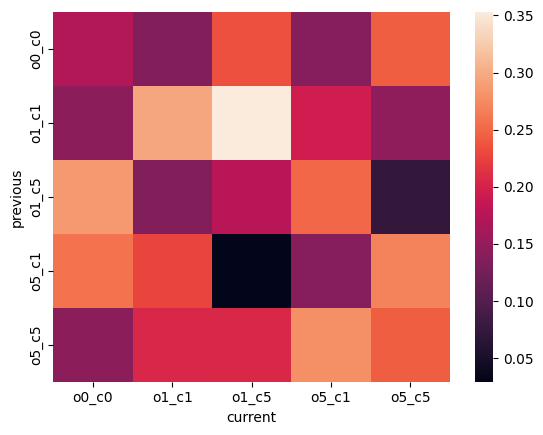

In [18]:
n_trials_sample = task_fr[['i_neuron','sample']].groupby(['sample']).count()
print(n_trials_sample)
sorted_samples = task_fr[['trial_idx','sample']].sort_values('trial_idx').reset_index(drop=True)['sample'].values
samples_dict = {'current':[],'previous':[]}
prev_sampl = sorted_samples[0]
for i_sample in sorted_samples[1:]:
    samples_dict['current'].append(i_sample)
    samples_dict['previous'].append(prev_sampl)
    prev_sampl = i_sample
samples_dict = pd.DataFrame(samples_dict)
curr_prev_sample = samples_dict.reset_index().groupby(['current','previous']).count().reset_index()
df = curr_prev_sample.pivot(index="previous", columns="current", values="index")
df['o0_c0'] = df['o0_c0']/n_trials_sample.loc['o0_c0'].values[0]
df['o1_c1'] = df['o1_c1']/n_trials_sample.loc['o1_c1'].values[0]
df['o1_c5'] = df['o1_c5']/n_trials_sample.loc['o1_c5'].values[0]
df['o5_c1'] = df['o5_c1']/n_trials_sample.loc['o5_c1'].values[0]
df['o5_c5'] = df['o5_c5']/n_trials_sample.loc['o5_c5'].values[0]
sns.heatmap(df)
df

In [19]:
print(df['o1_c1'].loc['o1_c1']+df['o1_c1'].loc['o1_c5'])
print(df['o1_c1'].loc['o5_c1']+df['o1_c1'].loc['o5_c5'])

0.4318181818181818
0.4318181818181818


In [20]:
print(df['o1_c5'].loc['o1_c1']+df['o1_c1'].loc['o1_c5'])
print(df['o1_c5'].loc['o5_c1']+df['o1_c1'].loc['o5_c5'])

0.4893048128342246
0.23395721925133692


/tmp/ipykernel_109233/2866712804.py:3: RuntimeWarning: invalid value encountered in cast
  test_stimuli_samp_str = test_stimuli_samp.astype(str)


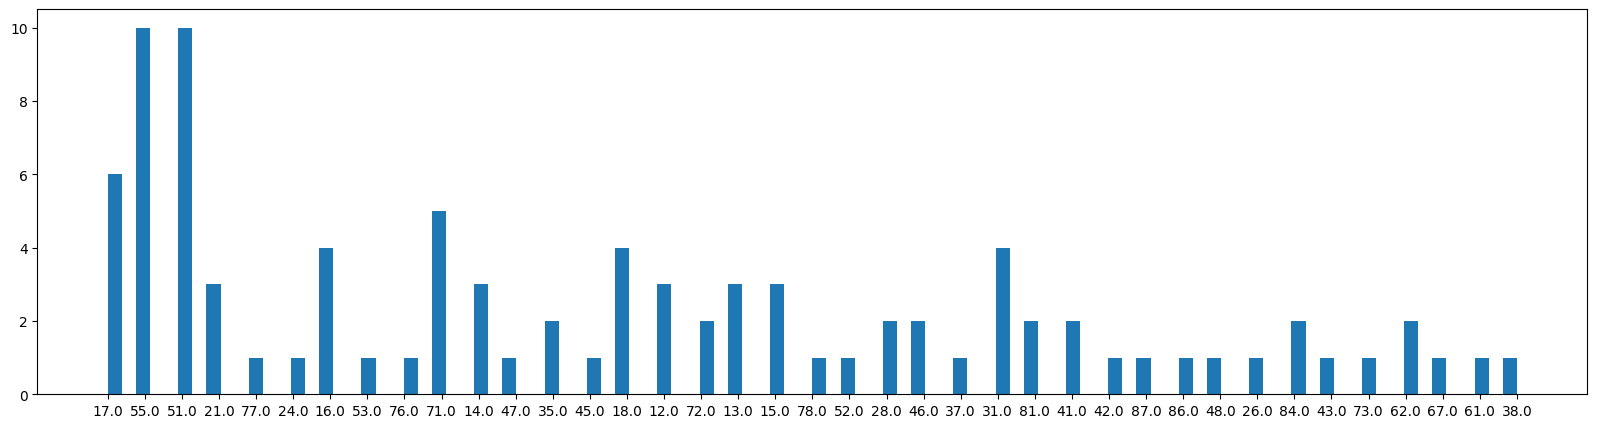

In [21]:
task_sample = task_fr[task_fr['sample']=='o1_c1']
test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
test_stimuli_samp_str = test_stimuli_samp.astype(str)
concat = np.concatenate(test_stimuli_samp_str)
concat = concat[np.where(np.logical_or(concat == 'nan',concat=='11.0'),False,True)]
fif,ax = plt.subplots(figsize=(20,5))
c=ax.hist(concat,bins=100)

<AxesSubplot: >

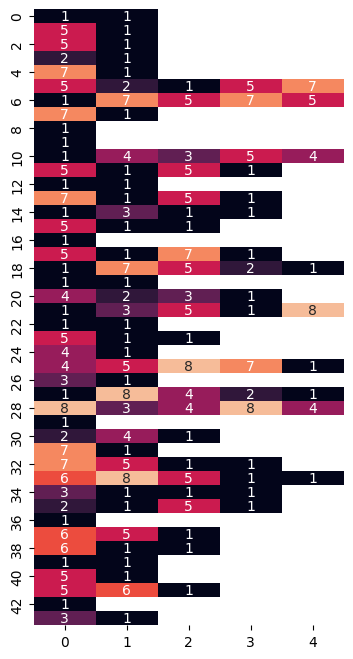

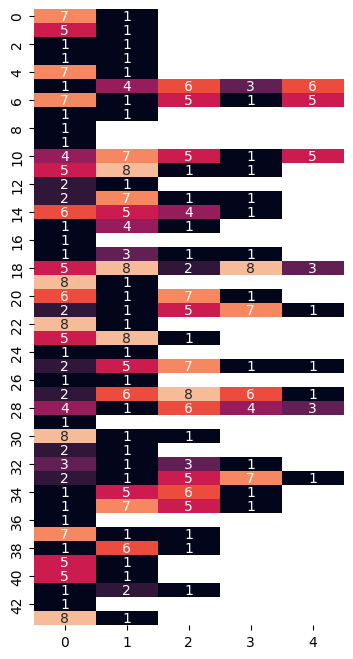

In [22]:
## orientation
test_stimuli_o1 = test_stimuli_samp//10
mask = np.where(np.isnan(test_stimuli_o1),True,False)
test_stimuli_o = pd.DataFrame(test_stimuli_o1)
fx = plt.subplots(figsize=(4,8))
sns.heatmap(test_stimuli_o,mask=mask,vmax = 9,annot=True,cbar=False)
## color
test_stimuli_c1 = test_stimuli_samp%10
mask = np.where(np.isnan(test_stimuli_c1),True,False) 
test_stimuli_c = pd.DataFrame(test_stimuli_c1)
fx = plt.subplots(figsize=(4,8))
sns.heatmap(test_stimuli_c,mask=mask,vmax = 9,annot=True,cbar=False)

/tmp/ipykernel_109233/1447410865.py:7: RuntimeWarning: invalid value encountered in cast
  test_stimuli_samp = test_stimuli_samp.astype(str)


o1_c1
o1c1 38
o5c5 10
o1c5 3
o5c1 10
o5_c5
o1c1 6
o5c5 33
o1c5 4
o5c1 9


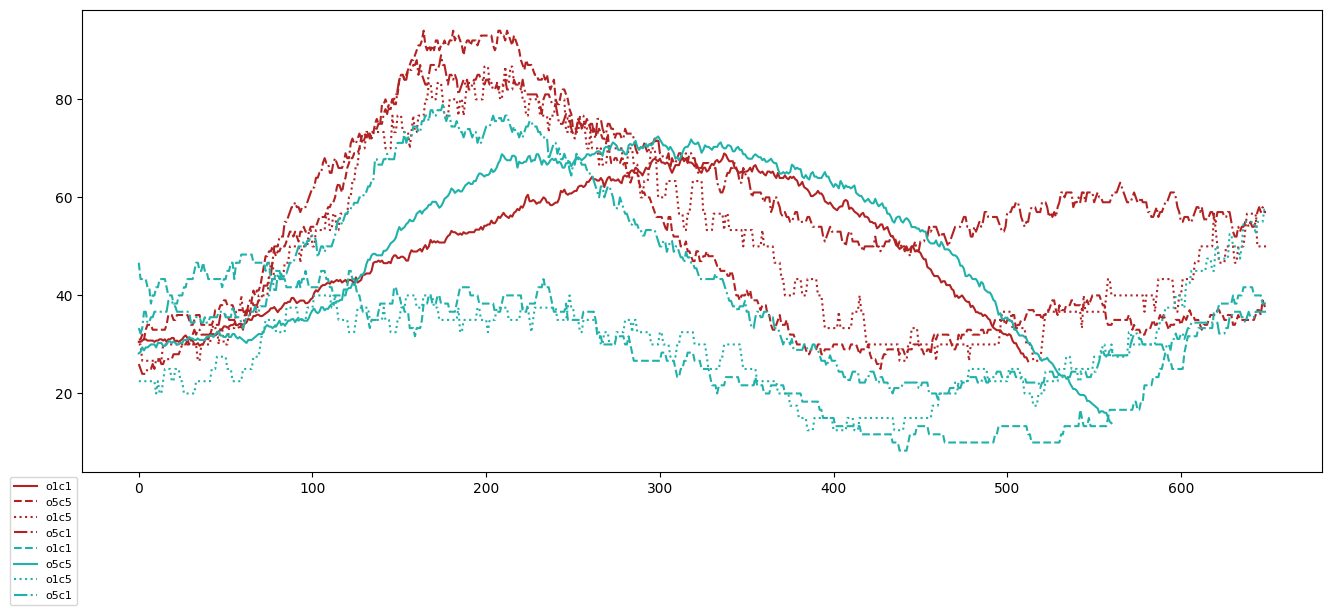

In [23]:
fig,ax = plt.subplots(figsize = (16,6))
for sample in ['o1_c1','o5_c5']:
    task_sample = task_fr[task_fr['sample']==sample]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    test_stimuli_samp = test_stimuli_samp.astype(str)

    test_stimuli_o1c1 = np.where(np.char.find(test_stimuli_samp,'11')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o1c1)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o1c1 = SpikeData.indep_roll(sp_stim, -(tests_on-t_before), axis=1)[:, :t_before+450+t_after]

    test_stimuli_o5c5 = np.where(np.char.find(test_stimuli_samp,'55')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o5c5)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o5c5 = SpikeData.indep_roll(sp_stim, -(tests_on-t_before), axis=1)[:, :t_before+450+t_after]

    test_stimuli_o1c5 = np.where(np.char.find(test_stimuli_samp,'15')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o1c5)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o1c5 = SpikeData.indep_roll(sp_stim, -(tests_on-t_before), axis=1)[:, :t_before+450+t_after]
    
    test_stimuli_o5c1 = np.where(np.char.find(test_stimuli_samp,'51')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o5c1)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o5c1 = SpikeData.indep_roll(sp_stim, -(tests_on-t_before), axis=1)[:, :t_before+450+t_after]

    print(sample)
    sp_tests_o1c1_avg = sp_tests_o1c1.mean(axis=0)
    print('o1c1 %d'%sp_tests_o1c1.shape[0])
    sp_tests_o5c5_avg = sp_tests_o5c5.mean(axis=0)
    print('o5c5 %d'%sp_tests_o5c5.shape[0])
    sp_tests_o1c5_avg = sp_tests_o1c5.mean(axis=0)
    print('o1c5 %d'%sp_tests_o1c5.shape[0])
    sp_tests_o5c1_avg = sp_tests_o5c1.mean(axis=0)
    print('o5c1 %d'%sp_tests_o5c1.shape[0])
    sp_tests_o1c1_avg = firing_rate.moving_average(data=sp_tests_o1c1_avg,win=win,step=1)[t_after-win:t_after+450+win]*1000
    sp_tests_o5c5_avg = firing_rate.moving_average(data=sp_tests_o5c5_avg,win=win,step=1)[t_after-win:t_after+450+win]*1000
    sp_tests_o1c5_avg = firing_rate.moving_average(data=sp_tests_o1c5_avg,win=win,step=1)[t_after-win:t_after+450+win]*1000
    sp_tests_o5c1_avg = firing_rate.moving_average(data=sp_tests_o5c1_avg,win=win,step=1)[t_after-win:t_after+450+win]*1000

    style1 = '-'
    style2 = '--'
    style3 = ':'
    style4 = '-.'
    if sample == 'o5_c5':
        style1 = '--'
        style2 = '-'
        style3 = ':'
        style4 = '-.'
    ax.plot(sp_tests_o1c1_avg,linestyle=style1,color=task_constants.PALETTE_B1[sample],label='o1c1')
    ax.plot(sp_tests_o5c5_avg,linestyle=style2,color=task_constants.PALETTE_B1[sample],label='o5c5')
    ax.plot(sp_tests_o1c5_avg,linestyle=style3,color=task_constants.PALETTE_B1[sample],label='o1c5')
    ax.plot(sp_tests_o5c1_avg,linestyle=style4,color=task_constants.PALETTE_B1[sample],label='o5c1')
    #ax.set_ylim(0,60)
    plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_109233/1534528036.py:7: RuntimeWarning: invalid value encountered in cast
  test_stimuli_samp = test_stimuli_samp.astype(str)


o1_c5
o1c1 10
o5c5 7
o1c5 28
o5c1 8
o5_c1
o1c1 5
o5c5 2
o1c5 14
o5c1 28


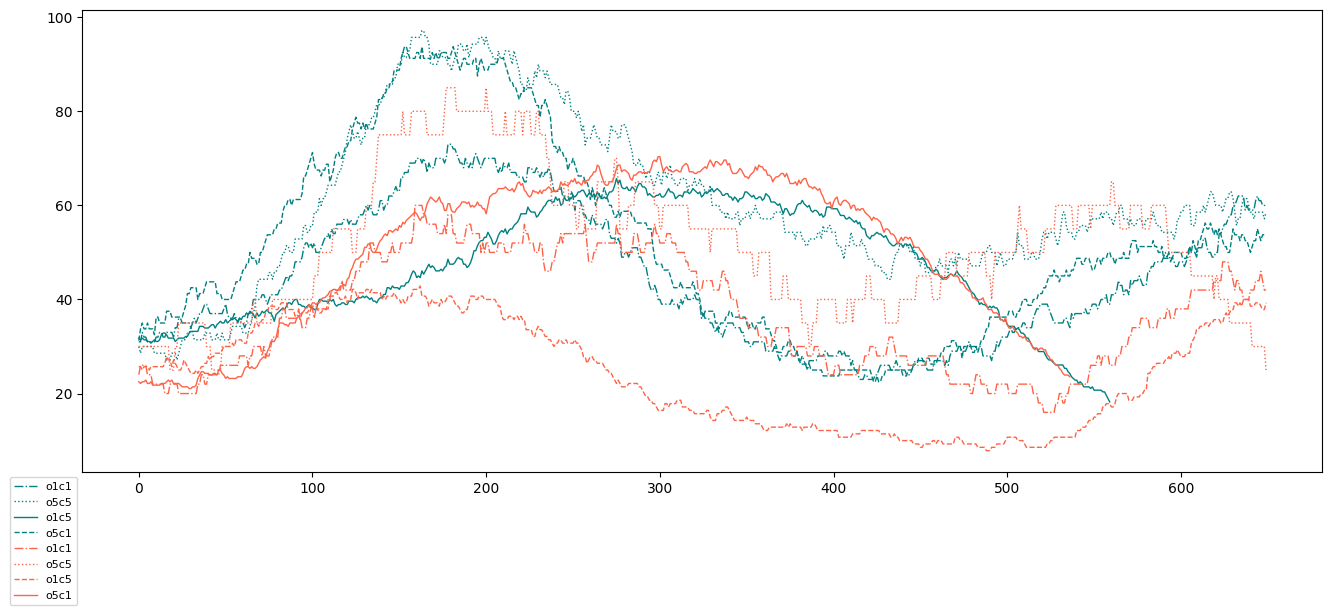

In [24]:
fig,ax = plt.subplots(figsize = (16,6))
for sample in ['o1_c5','o5_c1']:
    task_sample = task_fr[task_fr['sample']==sample]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    test_stimuli_samp = test_stimuli_samp.astype(str)

    test_stimuli_o1c1 = np.where(np.char.find(test_stimuli_samp,'11')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o1c1)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o1c1 = SpikeData.indep_roll(sp_stim, -(tests_on-t_before), axis=1)[:,  :t_before+450+t_after]

    test_stimuli_o5c5 = np.where(np.char.find(test_stimuli_samp,'55')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o5c5)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o5c5 = SpikeData.indep_roll(sp_stim, -(tests_on-t_before), axis=1)[:,  :t_before+450+t_after]

    test_stimuli_o1c5 = np.where(np.char.find(test_stimuli_samp,'15')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o1c5)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o1c5 = SpikeData.indep_roll(sp_stim, -(tests_on-t_before), axis=1)[:,  :t_before+450+t_after]
    
    test_stimuli_o5c1 = np.where(np.char.find(test_stimuli_samp,'51')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o5c1)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o5c1 = SpikeData.indep_roll(sp_stim, -(tests_on-t_before), axis=1)[:,  :t_before+450+t_after]

    print(sample)
    sp_tests_o1c1_avg = sp_tests_o1c1.mean(axis=0)
    print('o1c1 %d'%sp_tests_o1c1.shape[0])
    sp_tests_o5c5_avg = sp_tests_o5c5.mean(axis=0)
    print('o5c5 %d'%sp_tests_o5c5.shape[0])
    sp_tests_o1c5_avg = sp_tests_o1c5.mean(axis=0)
    print('o1c5 %d'%sp_tests_o1c5.shape[0])
    sp_tests_o5c1_avg = sp_tests_o5c1.mean(axis=0)
    print('o5c1 %d'%sp_tests_o5c1.shape[0])
    sp_tests_o1c1_avg = firing_rate.moving_average(data=sp_tests_o1c1_avg,win=win,step=1)[t_after-win:t_after+450+win]*1000
    sp_tests_o5c5_avg = firing_rate.moving_average(data=sp_tests_o5c5_avg,win=win,step=1)[t_after-win:t_after+450+win]*1000
    sp_tests_o1c5_avg = firing_rate.moving_average(data=sp_tests_o1c5_avg,win=win,step=1)[t_after-win:t_after+450+win]*1000
    sp_tests_o5c1_avg = firing_rate.moving_average(data=sp_tests_o5c1_avg,win=win,step=1)[t_after-win:t_after+450+win]*1000

    style1 = '-'
    style2 = '--'
    style3 = ':'
    style4 = '-.'
    if sample == 'o5_c1':
        style1 = '--'
        style2 = '-'
        style3 = ':'
        style4 = '-.'
    ax.plot(sp_tests_o1c1_avg,linestyle=style4,color=task_constants.PALETTE_B1[sample],label='o1c1',linewidth=1,markersize=4)
    ax.plot(sp_tests_o5c5_avg,linestyle=style3,color=task_constants.PALETTE_B1[sample],label='o5c5',linewidth=1,markersize=4)
    ax.plot(sp_tests_o1c5_avg,linestyle=style1,color=task_constants.PALETTE_B1[sample],label='o1c5',linewidth=1,markersize=4)
    ax.plot(sp_tests_o5c1_avg,linestyle=style2,color=task_constants.PALETTE_B1[sample],label='o5c1',linewidth=1,markersize=4)
    #ax.set_ylim(0,60)
    plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

o1_c1 38
o5_c5 33
o1_c5 28
o5_c1 28


/tmp/ipykernel_109233/1392039099.py:8: RuntimeWarning: invalid value encountered in cast
  test_stimuli_samp = test_stimuli_samp.astype(str)


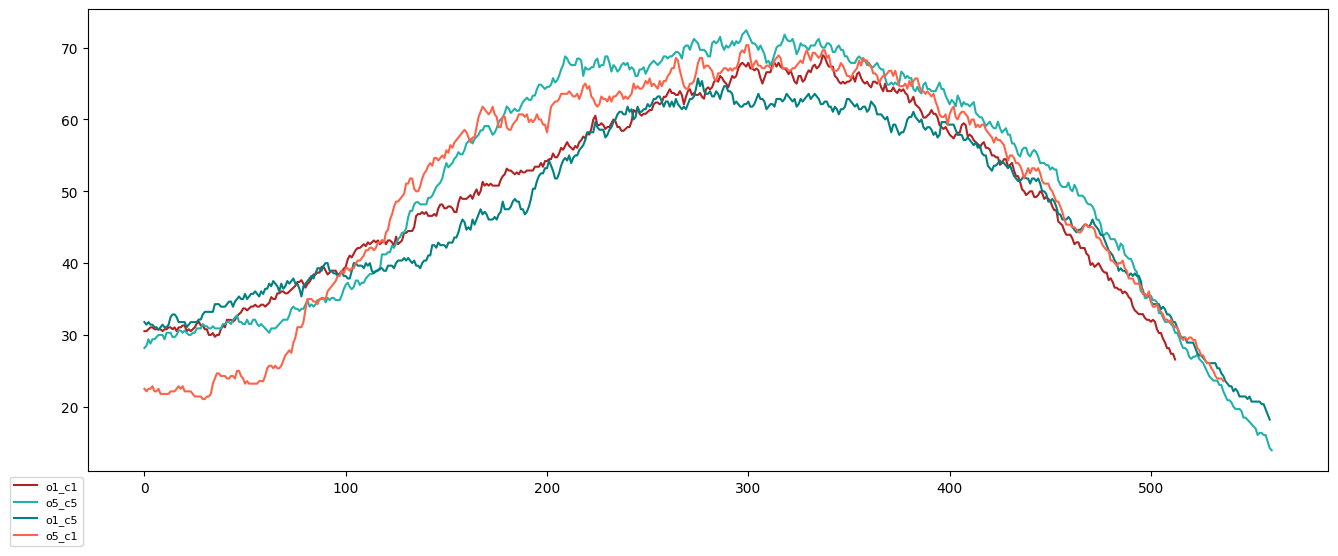

In [25]:
## Mean match response to each sample
fig,ax = plt.subplots(figsize = (16,6))
for sample in ['o1_c1','o5_c5','o1_c5','o5_c1']:
    task_sample = task_fr[task_fr['sample']==sample]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    test_stimuli_samp = test_stimuli_samp.astype(str)
    num_sample = sample[1]+sample[-1]
    test_stimuli_o1c1 = np.where(np.char.find(test_stimuli_samp,num_sample)==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o1c1)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o1c1 = SpikeData.indep_roll(sp_stim, -(tests_on-t_before), axis=1)[:, :t_after+550+t_before]

    sp_tests_o1c1_avg = sp_tests_o1c1.mean(axis=0)
    print('%s %d'%(sample,sp_tests_o1c1.shape[0]))
    sp_tests_o1c1_avg = firing_rate.moving_average(data=sp_tests_o1c1_avg,win=win,step=1)[t_after-win:t_after+450+win]*1000

    style1 = '-'
    ax.plot(sp_tests_o1c1_avg,linestyle=style1,color=task_constants.PALETTE_B1[sample],label=sample)

    # ax.set_ylim(0,25)
    plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Plot response by samples

In [26]:
len_t = 450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_sample_on = np.zeros((4,450))
all_sp_delay = np.zeros((4,450))
all_sp_test1 = np.zeros((4,450))
all_sp_test2=np.zeros((4,450))
all_sp_test3=np.zeros((4,450))
all_sp_test4=np.zeros((4,450))
all_sp_test5=np.zeros((4,450))

for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task_fr[task_fr['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    # sample on
    sp_sample_on = SpikeData.indep_roll(sp_samples_samp, -(code_samples_samp[:,4]-t_before).astype(int), axis=1)[:, :t_before+len_t+t_after+win]
    sp_sample_on = sp_sample_on.mean(axis=0)
    all_sp_sample_on[i] = firing_rate.moving_average(data=sp_sample_on,win=win,step=1)[t_before-int(win/2):t_before-int(win/2)+len_t]*1000
    # delay
    sp_delay = SpikeData.indep_roll(sp_samples_samp, -(code_samples_samp[:,5]-t_before).astype(int), axis=1)[:, :len_t+win+t_before+t_after]
    sp_delay = sp_delay.mean(axis=0)
    all_sp_delay[i] = firing_rate.moving_average(data=sp_delay,win=win,step=1)[t_before-int(win/2):t_before-int(win/2)+len_t]*1000
    # test 1
    idx = np.where(~np.isnan(code_samples_samp[:,6]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -(code_samples_samp[idx,6]-t_before).astype(int), axis=1)[:, :len_t+win+t_before+t_after]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test1[i] = firing_rate.moving_average(data=sp_test,win=win,step=1)[t_before-int(win/2):t_before-int(win/2)+len_t]*1000
    # test 2
    idx = np.where(~np.isnan(code_samples_samp[:,8]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -(code_samples_samp[idx,8]-t_before).astype(int), axis=1)[:, :len_t+win+t_before+t_after]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test2[i] = firing_rate.moving_average(data=sp_test,win=win,step=1)[t_before-int(win/2):t_before-int(win/2)+len_t]*1000
    # test 3
    idx = np.where(~np.isnan(code_samples_samp[:,10]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -(code_samples_samp[idx,10]-t_before).astype(int), axis=1)[:, :len_t+win+t_before+t_after]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test3[i] = firing_rate.moving_average(data=sp_test,win=win,step=1)[t_before-int(win/2):t_before-int(win/2)+len_t]*1000
    # test 4
    idx = np.where(~np.isnan(code_samples_samp[:,12]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -(code_samples_samp[idx,12]-t_before).astype(int), axis=1)[:, :len_t+win+t_before+t_after]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test4[i] = firing_rate.moving_average(data=sp_test,win=win,step=1)[t_before-int(win/2):t_before-int(win/2)+len_t]*1000
    # test 5
    idx = np.where(~np.isnan(code_samples_samp[:,14]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -(code_samples_samp[idx,14]-t_before).astype(int), axis=1)[:, :len_t+win+t_before+t_after]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test5[i] = firing_rate.moving_average(data=sp_test,win=win,step=1)[t_before-int(win/2):t_before-int(win/2)+len_t]*1000


/tmp/ipykernel_109233/1746242827.py:54: RuntimeWarning: Mean of empty slice.
  sp_test = sp_test[idx].mean(axis=0)
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


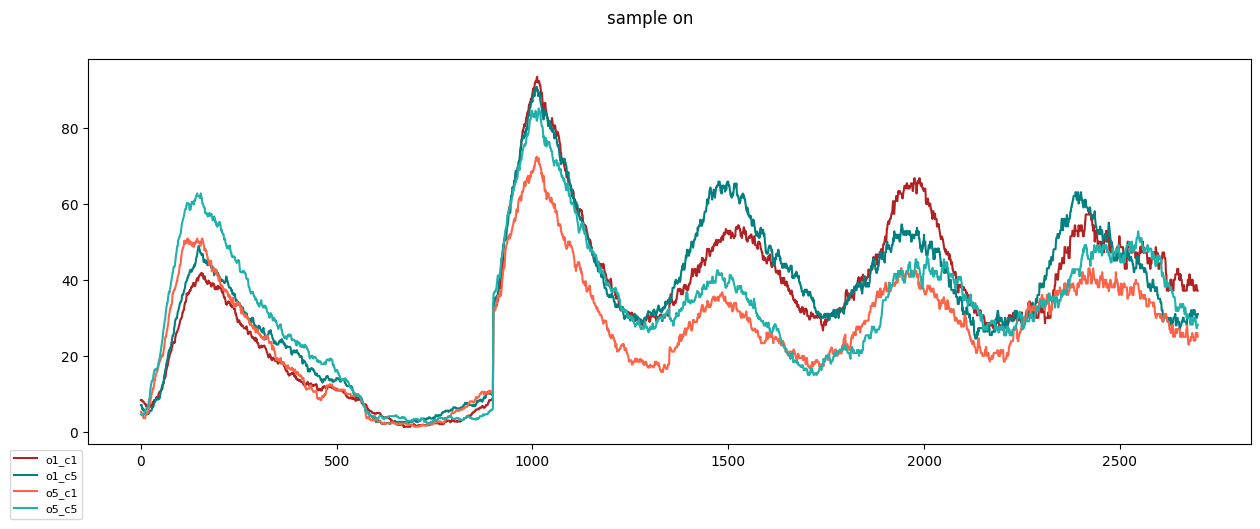

In [27]:
all_sp_epochs = np.concatenate([all_sp_sample_on,all_sp_delay,all_sp_test1,all_sp_test2,all_sp_test3,all_sp_test4,all_sp_test5],axis=1)
fig,ax = plt.subplots(figsize = (15,5))
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    ax.plot(all_sp_epochs[i],label=sample,color=task_constants.PALETTE_B1[sample])
fig.suptitle('sample on')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Plot response by feature (color 1, color 5, orientation 1, orientation 5)

In [28]:
win=100
all_sp_test1 = np.zeros((4,len_t+win))
all_sp_test2 = np.zeros((4,len_t+win))
all_sp_test3 = np.zeros((4,len_t+win))
all_sp_test4 = np.zeros((4,len_t+win))
all_sp_test5 = np.zeros((4,len_t+win))
all_sp_delay = np.zeros((4,len_t+win))
all_sp_sample_on = np.zeros((4,len_t+win))

for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task_fr[task_fr['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    # sample on
    sp_sample_on = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,4].astype(int), axis=1)[:, :len_t+win]
    all_sp_sample_on[i] = sp_sample_on.mean(axis=0)
    # delay
    sp_delay = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,5].astype(int), axis=1)[:, :len_t+win]
    all_sp_delay[i] = sp_delay.mean(axis=0)
    # test 1
    idx = np.where(~np.isnan(test_stimuli_samp[:,0]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,6].astype(int), axis=1)[:, :len_t+win]
    all_sp_test1[i] = sp_test.mean(axis=0)
    # test 2 
    idx = np.where(~np.isnan(test_stimuli_samp[:,1]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,8].astype(int), axis=1)[:, :len_t+win]
    all_sp_test2[i] = sp_test.mean(axis=0)
    # test 3
    idx = np.where(~np.isnan(test_stimuli_samp[:,2]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,10].astype(int), axis=1)[:, :len_t+win]    
    all_sp_test3[i] = sp_test.mean(axis=0)
    # test 4
    idx = np.where(~np.isnan(test_stimuli_samp[:,3]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,12].astype(int), axis=1)[:, :len_t+win]
    all_sp_test4[i] = sp_test.mean(axis=0)
    # test 5
    idx = np.where(~np.isnan(test_stimuli_samp[:,4]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,14].astype(int), axis=1)[:, :len_t+win]
    all_sp_test5[i] = sp_test.mean(axis=0)

all_sp_epochs_feture = [all_sp_sample_on,all_sp_delay,all_sp_test1,all_sp_test2,all_sp_test3,all_sp_test4,all_sp_test5]

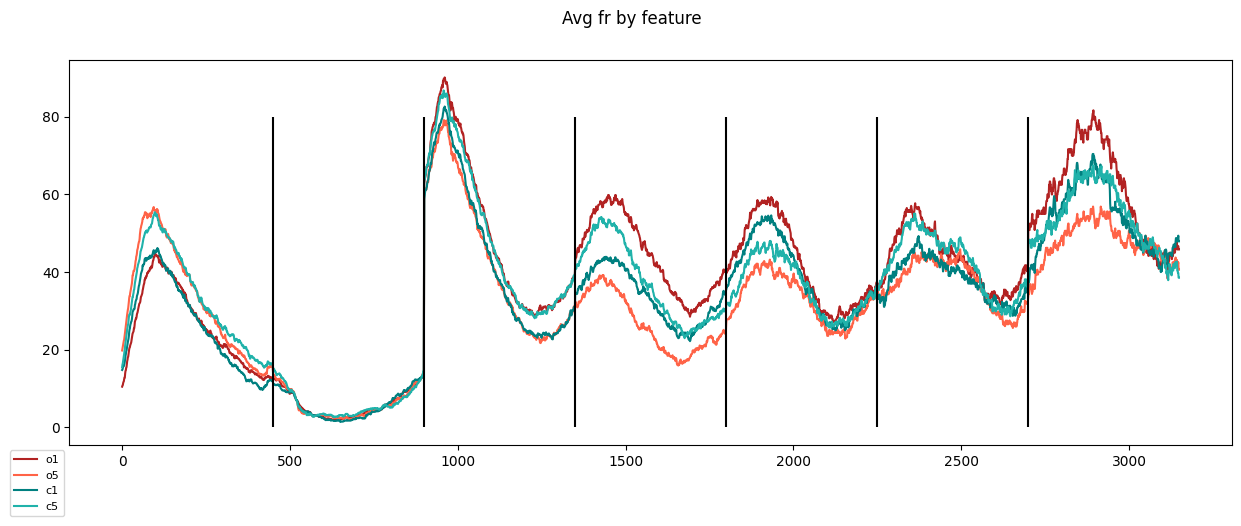

In [29]:
o1_avg_feature=[]
o5_avg_feature=[]
c1_avg_feature=[]
c5_avg_feature=[]
fig,ax = plt.subplots(figsize=(15,5))
for i,all_sp in enumerate(all_sp_epochs_feture):
    o1 = np.mean([all_sp[0],all_sp[1]],axis=0)
    o5 = np.mean([all_sp[2],all_sp[3]],axis=0)
    c1 = np.mean([all_sp[0],all_sp[2]],axis=0)
    c5 = np.mean([all_sp[1],all_sp[3]],axis=0)
    o1_avg_feature.append(firing_rate.moving_average(data=o1,win=win,step=1)[:450]*1000)
    o5_avg_feature.append(firing_rate.moving_average(data=o5,win=win,step=1)[:450]*1000)
    c1_avg_feature.append(firing_rate.moving_average(data=c1,win=win,step=1)[:450]*1000)
    c5_avg_feature.append(firing_rate.moving_average(data=c5,win=win,step=1)[:450]*1000)
o1_avg_feature=np.concatenate(o1_avg_feature)
o5_avg_feature=np.concatenate(o5_avg_feature)
c1_avg_feature=np.concatenate(c1_avg_feature)
c5_avg_feature=np.concatenate(c5_avg_feature)
ax.plot(o1_avg_feature,label='o1',color=task_constants.PALETTE_B1["o1_c1"])
ax.plot(o5_avg_feature,label='o5',color=task_constants.PALETTE_B1["o5_c1"])
ax.plot(c1_avg_feature,label='c1',color=task_constants.PALETTE_B1["o1_c5"])
ax.plot(c5_avg_feature,label='c5',color=task_constants.PALETTE_B1["o5_c5"])
ax.vlines([450,450*2,450*3,450*4,450*5,450*6],0,80,color='k')
fig.suptitle('Avg fr by feature')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Average trials by test number and feature

In [30]:
len_t1_on=450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_test1 = np.zeros((4,len_t1_on+win))

all_sample_feature_tests = {"o1_c1":{"color":{},"orientation":{}},"o1_c5":{"color":{},"orientation":{}},"o5_c1":{"color":{},"orientation":{}},"o5_c5":{"color":{},"orientation":{}}}
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    color_tests = []
    orient_tests = []
    task_sample = task_fr[task_fr['sample']==sample]
    trials = task_sample['trial_idx'].values
    test_stimuli_samp = test_stimuli[trials]
    code_numbers_samp = code_numbers[trials]
    code_samples_samp = code_samples[trials]
    sp_samples_samp = sp_samples[trials]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    
    for n_t in range(test_stimuli_samp.shape[1]):
        n_test = np.full(test_stimuli_samp.shape,np.nan)
        n_test[:,n_t] = test_stimuli_samp[:,n_t]
        color_tests=get_sp_feature(sp_samples_samp,n_test,code_samples_samp,color_orient="color",stim_num=stim_num)
        orient_tests=get_sp_feature(sp_samples_samp,n_test,code_samples_samp,color_orient="orient",stim_num=stim_num)
        all_sample_feature_tests[sample]["color"][str(n_t)]= color_tests
        all_sample_feature_tests[sample]["orientation"][str(n_t)]= orient_tests

/tmp/ipykernel_109233/2384827628.py:6: RuntimeWarning: Mean of empty slice.
  tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][i].mean(axis=0)


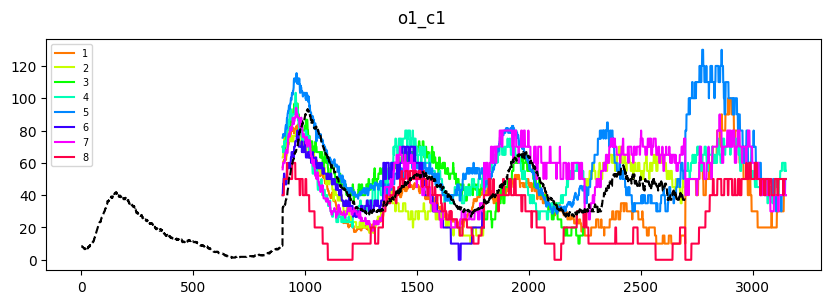

In [31]:
palette = plt.get_cmap('hsv',64)
o1_c1_orient = []
for i_test in range(5):
    o1_c1_orient_test = []
    for i in range(8):
        tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][i].mean(axis=0)
        tests = firing_rate.moving_average(data=tests,win=win,step=1)*1000
        o1_c1_orient_test.append(tests[:450])   
    o1_c1_orient.append(o1_c1_orient_test)

palette = plt.get_cmap('hsv',64)
all_o1_tests = np.concatenate([o1_c1_orient[0],o1_c1_orient[1],o1_c1_orient[2],o1_c1_orient[3],o1_c1_orient[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_o1_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(all_sp_epochs[0],'k--')
fig.suptitle('o1_c1')
plt.legend( prop={'size': 7})

Text(0.5, 0.98, 'o1_c1')

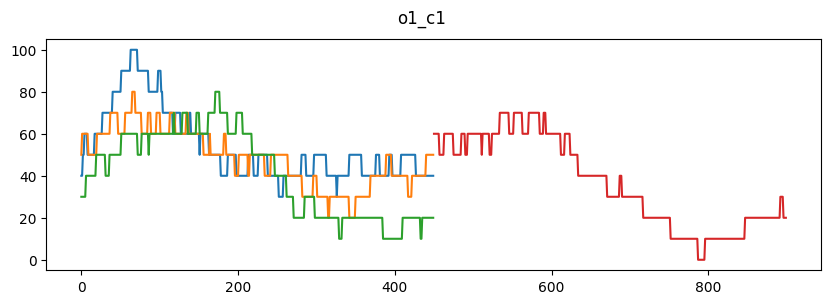

In [32]:
o1_c1_orient = []
for i_test in range(5):
    o1_c1_orient_test = []
    tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][5]
    for i_test in tests:
        i_test = firing_rate.moving_average(data=i_test,win=win,step=1)*1000
        o1_c1_orient_test.append(i_test[:450])   
    o1_c1_orient.append(o1_c1_orient_test)
palette = plt.get_cmap('hsv',64)
#all_o1_tests = np.concatenate([o1_c1_orient[0],o1_c1_orient[1],o1_c1_orient[2],o1_c1_orient[3],o1_c1_orient[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i_tr in o1_c1_orient[0]:
    ax.plot(i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[1]:
    ax.plot(np.arange(450,450*2),i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[2]:
    ax.plot(np.arange(450*2,450*3),i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[3]:
    ax.plot(np.arange(450*3,450*4),i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[4]:
    ax.plot(np.arange(450*4,450*5),i_tr,label=stim_num[i])
#ax.plot(all_sp_epochs[0],'k--')
fig.suptitle('o1_c1')


Text(0.5, 0.98, 'o1_c1')

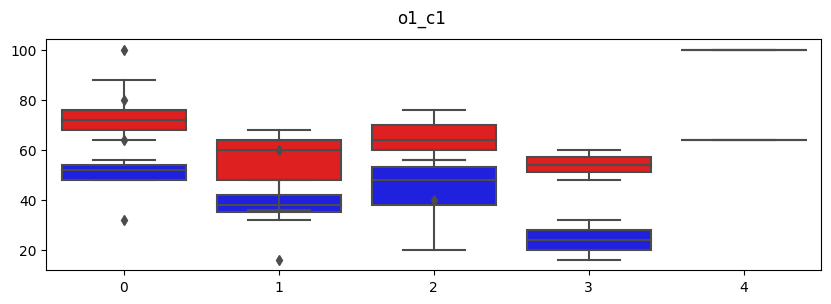

In [33]:
o1_c1_orient0 = []
o1_c1_orient5 = []
for i_test in range(5):
    tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][0]
    o1_c1_orient0.append(tests[:,100:350].mean(axis=1)*1000)   
    tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][4]
    o1_c1_orient5.append(tests[:,100:350].mean(axis=1)*1000)   

palette = plt.get_cmap('hsv',64)
#all_o1_tests = np.concatenate([o1_c1_orient[0],o1_c1_orient[1],o1_c1_orient[2],o1_c1_orient[3],o1_c1_orient[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
sns.boxplot(o1_c1_orient0,color='b')
sns.boxplot(o1_c1_orient5,color='r')
fig.suptitle('o1_c1')

In [34]:
o1_tests = []
o5_tests = []
c1_tests = []
c5_tests = []
for i_test in range(5):
    o1,o5,c1,c5 = [],[],[],[]
    for i in range(8):
        o1_avg = np.array([all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o1_c5"]['orientation'][str(i_test)][i].mean(axis=0)])
        o1_avg = np.mean(o1_avg,axis=0)
        o1_avg = firing_rate.moving_average(data=o1_avg,win=win,step=1)*1000
        o1.append(o1_avg[:450])
        # o5.append()
        o5_avg = np.array([all_sample_feature_tests["o5_c1"]['orientation'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c5"]['orientation'][str(i_test)][i].mean(axis=0)])
        o5_avg = np.mean(o5_avg,axis=0)
        o5_avg = firing_rate.moving_average(data=o5_avg,win=win,step=1)*1000
        o5.append(o5_avg[:450])
        # c1.append()
        c1_avg = np.array([all_sample_feature_tests["o1_c1"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c1"]['color'][str(i_test)][i].mean(axis=0)])
        c1_avg = np.mean(c1_avg,axis=0)
        c1_avg = firing_rate.moving_average(data=c1_avg,win=win,step=1)*1000
        c1.append(c1_avg[:450])
        # c5.append()
        c5_avg = np.array([all_sample_feature_tests["o1_c5"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c5"]['color'][str(i_test)][i].mean(axis=0)])
        c5_avg = np.mean(c5_avg,axis=0)
        c5_avg = firing_rate.moving_average(data=c5_avg,win=win,step=1)*1000
        c5.append(c5_avg[:450])
    o1_tests.append(o1)
    o5_tests.append(o5)
    c1_tests.append(c1)
    c5_tests.append(c5)

/tmp/ipykernel_109233/2030598158.py:13: RuntimeWarning: Mean of empty slice.
  o5_avg = np.array([all_sample_feature_tests["o5_c1"]['orientation'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c5"]['orientation'][str(i_test)][i].mean(axis=0)])
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_109233/2030598158.py:18: RuntimeWarning: Mean of empty slice.
  c1_avg = np.array([all_sample_feature_tests["o1_c1"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c1"]['color'][str(i_test)][i].mean(axis=0)])
/tmp/ipykernel_109233/2030598158.py:23: RuntimeWarning: Mean of empty slice.
  c5_avg = np.array([all_sample_feature_tests["o1_c5"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c5"]['color'][str(i_test)][i].mean(axis=0)])
/tmp/ipykernel_109233/2030598158.py:8: RuntimeWarning: Mean of empty slic

In [35]:

dictio = {'0':[],'1':[],'2':[],'3':[],'4':[]}
for i_test in range(5):
    o1,o5,c1,c5 = [],[],[],[]
    for i in range(8):
        n_trials = all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][i].shape[0]+all_sample_feature_tests["o1_c5"]['orientation'][str(i_test)][i].shape[0]
        dictio[str(i_test)].append(n_trials)


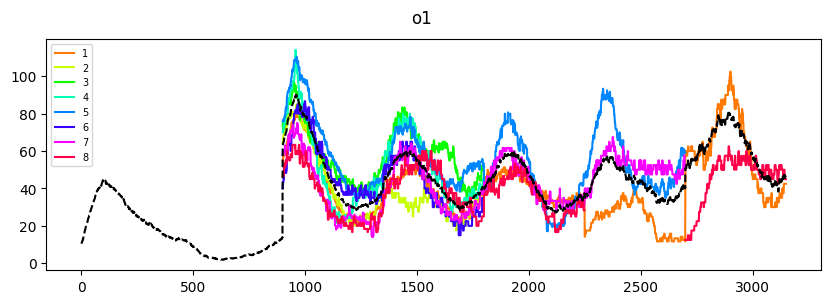

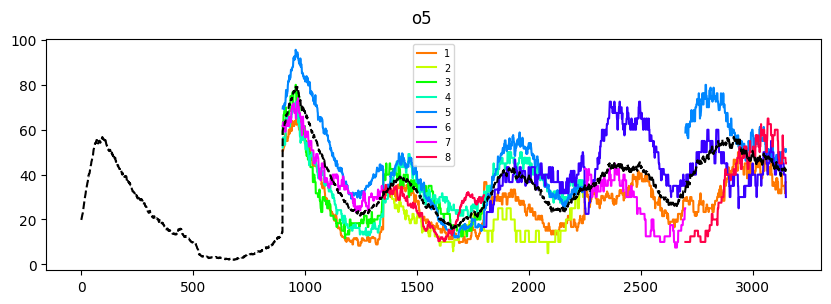

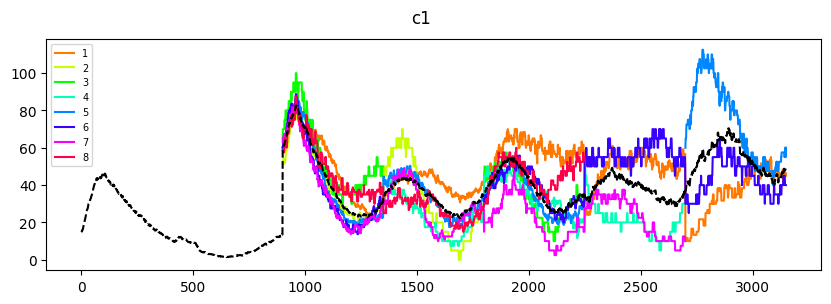

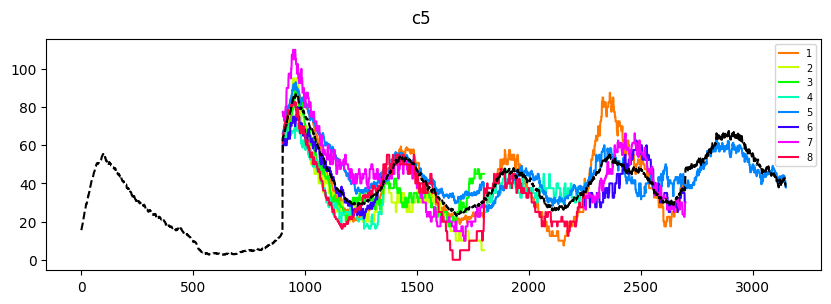

In [36]:
palette = plt.get_cmap('hsv',64)
all_o1_tests = np.concatenate([o1_tests[0],o1_tests[1],o1_tests[2],o1_tests[3],o1_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_o1_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(o1_avg_feature,'k--')
fig.suptitle('o1')
plt.legend( prop={'size': 7})

all_o5_tests = np.concatenate([o5_tests[0],o5_tests[1],o5_tests[2],o5_tests[3],o5_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_o5_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(o5_avg_feature,'k--')
fig.suptitle('o5')
plt.legend( prop={'size': 7})

all_c1_tests = np.concatenate([c1_tests[0],c1_tests[1],c1_tests[2],c1_tests[3],c1_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_c1_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(c1_avg_feature,'k--')
fig.suptitle('c1')
plt.legend( prop={'size': 7})

all_c5_tests = np.concatenate([c5_tests[0],c5_tests[1],c5_tests[2],c5_tests[3],c5_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_c5_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(c5_avg_feature,'k--')
fig.suptitle('c5')
plt.legend( prop={'size': 7})

### Average trials by test feature

In [37]:
len_t1_on=450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_test1 = np.zeros((4,len_t1_on+win))

all_sample_feature = {"o1_c1":{"color":[],"orientation":[]},"o1_c5":{"color":[],"orientation":[]},"o5_c1":{"color":[],"orientation":[]},"o5_c5":{"color":[],"orientation":[]}}
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):

    task_sample = task_fr[task_fr['sample']==sample]
    trials = task_sample['trial_idx'].values
    test_stimuli_samp = test_stimuli[trials]
    code_numbers_samp = code_numbers[trials]
    code_samples_samp = code_samples[trials]
    sp_samples_samp = sp_samples[trials]
    
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    
    color_tests = get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient="color",stim_num=stim_num)
    orient_tests = get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient="orient",stim_num=stim_num)

    all_sample_feature[sample]["color"]= color_tests
    all_sample_feature[sample]["orientation"]= orient_tests

In [38]:
o1_mean_sample = []
o5_mean_sample = []
c1_mean_sample = []
c5_mean_sample = []
for i in range(8):
    o1_mean_sample.append(np.array([all_sample_feature["o1_c1"]['orientation'][i].mean(axis=0),all_sample_feature["o1_c5"]['orientation'][i].mean(axis=0)]))
    # print("o1 - o%d n trials: %d"%(i,o1[i].shape[0]))
    o5_mean_sample.append(np.array([all_sample_feature["o5_c1"]['orientation'][i].mean(axis=0),all_sample_feature["o5_c5"]['orientation'][i].mean(axis=0)]))
    # print("o5 - o%d n trials: %d"%(i,o5[i].shape[0]))
    c1_mean_sample.append(np.array([all_sample_feature["o1_c1"]['color'][i].mean(axis=0),all_sample_feature["o5_c1"]['color'][i].mean(axis=0)]))
    # print("c1 - c%d n trials: %d"%(i,c1[i].shape[0]))
    c5_mean_sample.append(np.array([all_sample_feature["o1_c5"]['color'][i].mean(axis=0),all_sample_feature["o5_c5"]['color'][i].mean(axis=0)]))
    # print("c5 - c%d n trials: %d"%(i,c5[i].shape[0]))

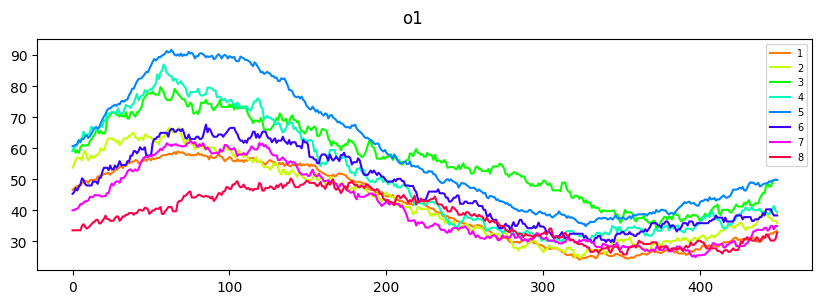

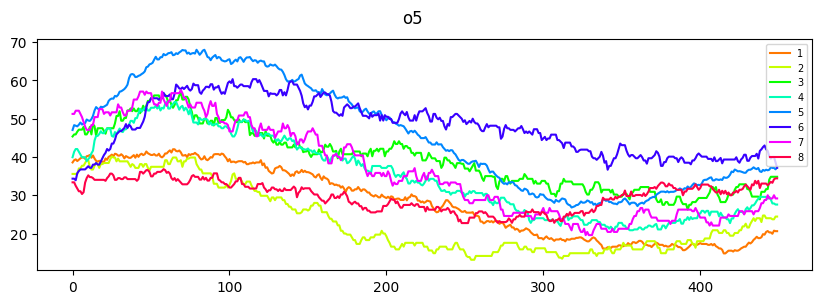

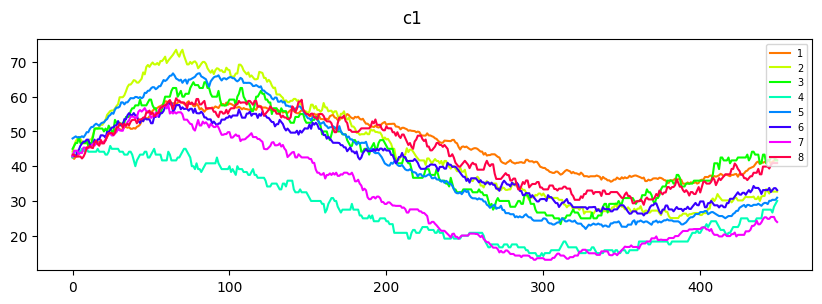

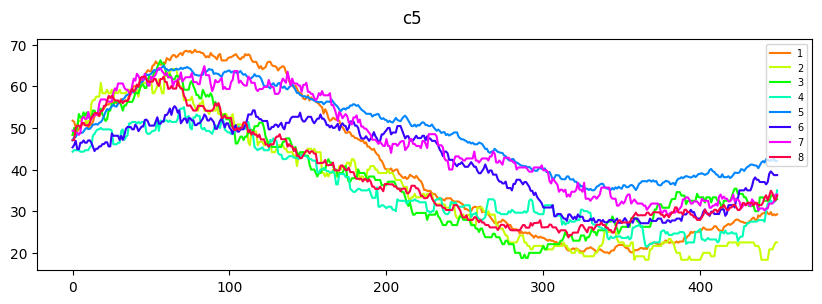

In [39]:
palette = plt.get_cmap('hsv',64)
len_d=450
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(o1_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = firing_rate.moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    # ax.set_ylim(0,25)
    fig.suptitle('o1')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(o5_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = firing_rate.moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    # ax.set_ylim(0,25)
    fig.suptitle('o5')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(c1_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = firing_rate.moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    # ax.set_ylim(0,25)
    fig.suptitle('c1')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(c5_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = firing_rate.moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    # ax.set_ylim(0,25)
    fig.suptitle('c5')
    plt.legend( prop={'size': 7})

### Avg activity by test feature

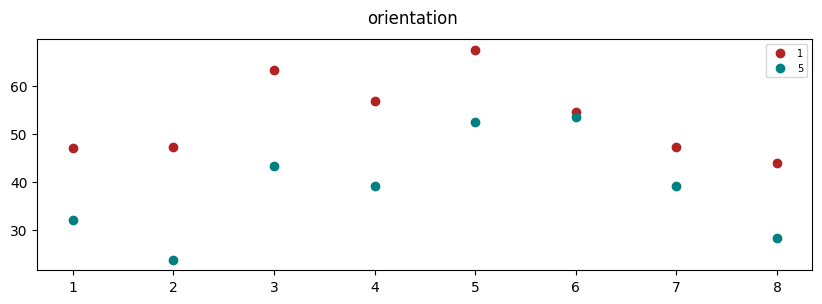

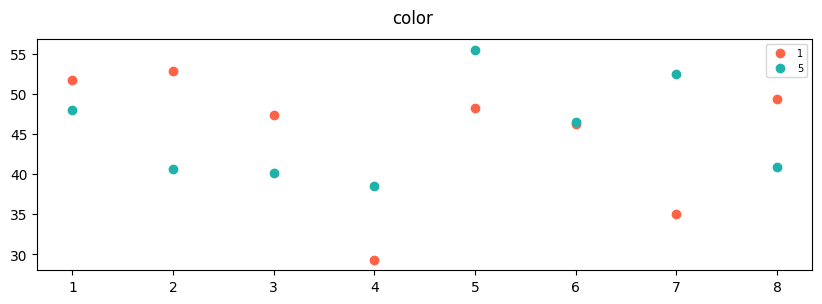

In [40]:
sample=["o1_c1","o5_c1","o1_c5","o5_c5"]
fig,ax = plt.subplots(figsize=(10,3))
o1_i_all=[]
o5_i_all=[]
for i, (o1_i,o5_i) in enumerate(zip(o1_mean_sample,o5_mean_sample)):
    o1_i_all.append(o1_i[:,100:350].mean()*1000)
    o5_i_all.append(o5_i[:,100:350].mean()*1000)
    
ax.scatter(range(1,9),o1_i_all,color=task_constants.PALETTE_B1[sample[0]],label='1')
ax.scatter(range(1,9),o5_i_all,color=task_constants.PALETTE_B1[sample[2]],label='5')
fig.suptitle('orientation')
ax.legend( prop={'size': 7})

fig,ax = plt.subplots(figsize=(10,3))
c1_i_all=[]
c5_i_all=[]
for i, (c1_i,c5_i) in enumerate(zip(c1_mean_sample,c5_mean_sample)):
    c1_i_all.append(c1_i[:,100:350].mean()*1000)
    c5_i_all.append(c5_i[:,100:350].mean()*1000)
    
ax.scatter(range(1,9),c1_i_all,color=task_constants.PALETTE_B1[sample[1]],label='1')
ax.scatter(range(1,9),c5_i_all,color=task_constants.PALETTE_B1[sample[3]],label='5')
fig.suptitle('color')
ax.legend( prop={'size': 7})

## Check if selective to color or orientation

In [41]:
o1_all = []
o5_all = []
c1_all = []
c5_all = []
for i in range(8):
    o1_all.append(np.concatenate([all_sample_feature["o1_c1"]['orientation'][i],all_sample_feature["o1_c5"]['orientation'][i]],axis=0))
    print("o1 - o%d n trials: %d"%(i,o1_all[i].shape[0]))
    o5_all.append(np.concatenate([all_sample_feature["o5_c1"]['orientation'][i],all_sample_feature["o5_c5"]['orientation'][i]],axis=0))
    print("o5 - o%d n trials: %d"%(i,o5_all[i].shape[0]))
    c1_all.append(np.concatenate([all_sample_feature["o1_c1"]['color'][i],all_sample_feature["o5_c1"]['color'][i]],axis=0))
    print("c1 - c%d n trials: %d"%(i,c1_all[i].shape[0]))
    c5_all.append(np.concatenate([all_sample_feature["o1_c5"]['color'][i],all_sample_feature["o5_c5"]['color'][i]],axis=0))
    print("c5 - c%d n trials: %d"%(i,c5_all[i].shape[0]))

o1 - o0 n trials: 49
o5 - o0 n trials: 36
c1 - c0 n trials: 49
c5 - c0 n trials: 39
o1 - o1 n trials: 13
o5 - o1 n trials: 12
c1 - c1 n trials: 16
c5 - c1 n trials: 8
o1 - o2 n trials: 14
o5 - o2 n trials: 11
c1 - c2 n trials: 9
c5 - c2 n trials: 10
o1 - o3 n trials: 14
o5 - o3 n trials: 17
c1 - c3 n trials: 12
c5 - c3 n trials: 16
o1 - o4 n trials: 38
o5 - o4 n trials: 51
c1 - c4 n trials: 34
c5 - c4 n trials: 57
o1 - o5 n trials: 11
o5 - o5 n trials: 17
c1 - c5 n trials: 17
c5 - c5 n trials: 14
o1 - o6 n trials: 19
o5 - o6 n trials: 10
c1 - c6 n trials: 20
c5 - c6 n trials: 13
o1 - o7 n trials: 15
o5 - o7 n trials: 18
c1 - c7 n trials: 14
c5 - c7 n trials: 17


In [42]:
o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg=[],[],[],[]
n_trials=[]
for i in range(8):
    n_tr=[]
    avg = o1_all[i][:,50:300].mean(axis=1)*1000
    o1_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = o5_all[i][:,50:300].mean(axis=1)*1000
    o5_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = c1_all[i][:,50:300].mean(axis=1)*1000
    c1_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = c5_all[i][:,50:300].mean(axis=1)*1000
    c5_trial_avg.append(avg)
    n_tr.append(len(avg))
    n_trials.append(n_tr)

### Plot

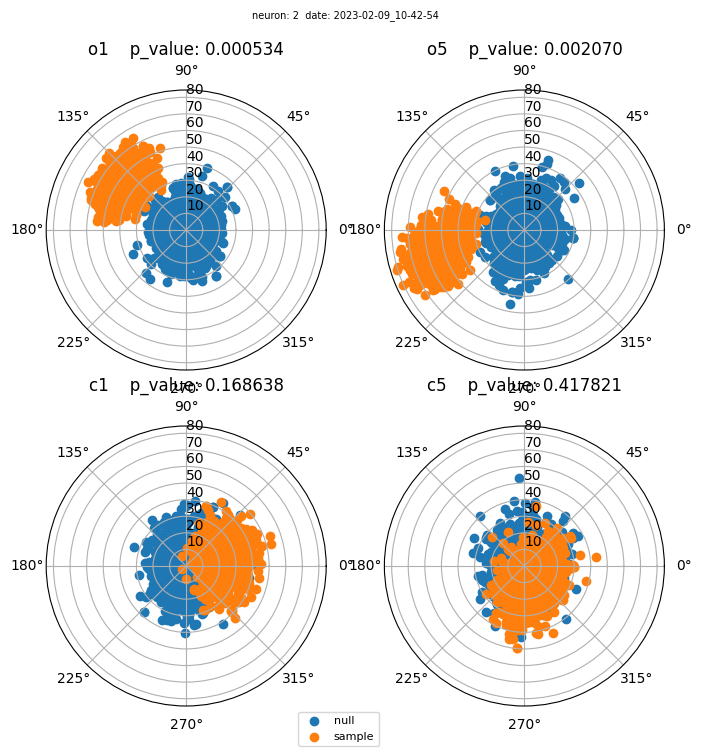

In [43]:
selectivity_info: Dict[str, list] = defaultdict(list)

min_n_trials = np.min(n_trials,axis=1).astype(int)
all_select = []
all_null=[]
all_p_value=[]
for trial_avg,feature in zip([o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg],['o1','o5','c1','c5']):

    if np.sum(min_n_trials<3)>0 or np.concatenate(trial_avg).sum()==0:
        p_value = np.nan
        mean_null = np.zeros((2,2))
        mean_select = np.zeros((2,2))
    else:
        mean_select = select_rand_trials_from_samples(trial_avg,min_n_trials,seed,n_iterations=1000)
        mean_null = get_null_vector_from_samples(trial_avg,min_n_trials,seed,n_iterations=1000)
        p_value = permutation_test(mean_select,mean_null)

    all_select.append(mean_select)
    all_null.append(mean_null)
    all_p_value.append(p_value)
    selectivity_info['date'] += [date]
    selectivity_info['i_neuron'] += [i_neuron]
    selectivity_info['neuron_type'] += [data.clustersgroup[i_neuron]]
    selectivity_info['p_value'] += [p_value]
    selectivity_info['sample1'] += [feature]

selectivity_info = pd.DataFrame(selectivity_info) 

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
for i,(ax, feature)in enumerate(zip([ax1,ax2,ax3,ax4],['o1','o5','c1','c5'])):
    ax.set_rlabel_position(90)
    ax.scatter(all_null[i][:,1],all_null[i][:,0],label='null')
    ax.scatter(all_select[i][:,1],all_select[i][:,0],label='sample')
    ax.set_title('%s    p_value: %f'%(feature,all_p_value[i]) )
fig.suptitle('neuron: %d  date: %s'%(i_neuron,date),fontsize=7)

plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

In [44]:
pref_dir_o1_0 = np.abs(0-all_select[0][:,1]*180/np.pi) 
pref_dir_o5_0 = np.abs(0-all_select[1][:,1]*180/np.pi)
diff=[]
for i in range(len(pref_dir_o1_0)):
    shift = np.concatenate([pref_dir_o1_0[i:],pref_dir_o1_0[:i]])
    diff.append(shift-pref_dir_o5_0)
diff=np.concatenate(diff)
p_value_away_o = 1-np.sum(diff>0)/len(diff)
p_value_toward_o = 1-np.sum(diff<0)/len(diff)

pref_dir_c1_0 = np.abs(all_select[2][:,1]*180/np.pi - 0) 
pref_dir_c5_0 = np.abs(all_select[3][:,1]*180/np.pi - 0)
diff=[]
for i in range(len(pref_dir_o1_0)):
    shift = np.concatenate([pref_dir_c1_0[i:],pref_dir_c1_0[:i]])
    diff.append(shift-pref_dir_c5_0)
diff=np.concatenate(diff)
p_value_away_c = 1-np.sum(diff>0)/len(diff)
p_value_toward_c = 1-np.sum(diff<0)/len(diff)

In [45]:
print(p_value_away_o)
print(p_value_away_c)

0.952408
0.835561


In [46]:
print(np.mean(pref_dir_o1_0))
print(np.mean(pref_dir_o5_0))

143.03098321491098
166.7920217485852


/tmp/ipykernel_109233/4024120114.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['o1','o2','o3','o4','o5','o6','o7','o8'])
/tmp/ipykernel_109233/4024120114.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['c1','c2','c3','c4','c5','c6','c7','c8'])


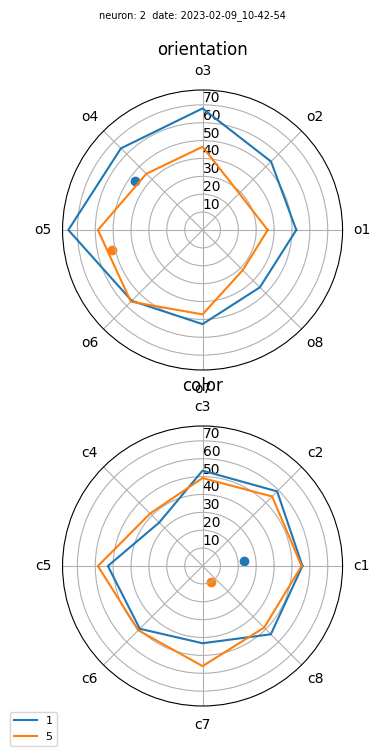

In [48]:
stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
min_n_trials = np.min(n_trials,axis=1).astype(int)
dir_vector = []
all_mean_resp=[]
for trial_avg,feature in zip([o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg],['o1','o5','c1','c5']):
    if np.sum(min_n_trials<3)>0:
        p_value = np.nan
        mean_null = np.zeros((2,2))
        mean_select = np.zeros((2,2))
        mean_resp = np.zeros((8,3))
    else:
        mean_select=[]
        mean_resp = np.zeros((8,3))
        for i_num in range(8):
            fr = trial_avg[i_num]
            mean_resp[i_num] = [np.mean(fr),np.std(fr),stim_angle[i_num]]
    dir_vector.append(circular_stats.direction_vector(mean_resp[:,0], mean_resp[:,2]))
    all_mean_resp.append(mean_resp)
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),sharey=True,subplot_kw={'projection': 'polar'})
for i,(ax, feature)in enumerate(zip([ax1,ax1,ax2,ax2],['o1','o5','c1','c5'])):
    ax.set_rlabel_position(90)
    mean_angle = np.concatenate([all_mean_resp[i][:,2],[all_mean_resp[i][0,2]]])
    mean_fr = np.concatenate([all_mean_resp[i][:,0],[all_mean_resp[i][0,0]]])
    ax.plot(mean_angle, mean_fr ,label=['1','5','1','5'][i])
    ax.scatter(dir_vector[i][1],dir_vector[i][0])
    title = 'color'
    
    if feature in ['o1','o5']:
        title = 'orientation'

    #ax.plot(all_mean_resp[i][:,2],all_mean_resp[i][:,0]+all_mean_resp[i][:,1],label='std')
    ax.set_title(title)
ax1.set_xticklabels(['o1','o2','o3','o4','o5','o6','o7','o8'])
ax2.set_xticklabels(['c1','c2','c3','c4','c5','c6','c7','c8'])    
fig.suptitle('neuron: %d  date: %s'%(i_neuron,date),fontsize=7)
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})